In [26]:
#packages
import numpy as np
import scipy.optimize as opt
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import scipy.integrate as intgr
import numpy.linalg as lin
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from pandas import Series, DataFrame


#logistic regression packages
import sklearn as sk
from sklearn import preprocessing
from sklearn import datasets, neighbors, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pylab import rcParams
import seaborn as sb



plt.style.use("ggplot")
%matplotlib inline

#data
incomes = np.loadtxt('incomes.txt')
df = pd.read_csv("sick.txt")
inc_sim = np.linspace(0.01, 150000, 200) #fake data.

#initial guesses
sig_init = 0.5
mu_init = 11
params_init = [mu_init,sig_init]

#mle args
mle_args = (incomes, 150000) # real data, cutoff

In [16]:
#lognormal functions
def log_norm_pdf(xvals, mu, sigma, cutoff):## log normal dist w/ truncated
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = sts.lognorm.cdf(cutoff, s=sigma, loc=mu, scale=np.exp(mu)) # use lognormal CDF function
            
    log_pdf_vals = (((1/(xvals * sigma * np.sqrt(2 * np.pi))) *
                    np.exp( - ((np.log(xvals)) - mu)**2 / (2 * sigma**2))) / 
                    prob_notcut)
    return log_pdf_vals 

def log_lik_norm(xvals, mu, sigma, cutoff): ## log liklihood for lognormal
    pdf_vals = log_norm_pdf(xvals, mu, sigma, cutoff) #this is the line that makes it lognormal 
    ln_pdf_vals = np.log(pdf_vals) 
    log_lik_val = ln_pdf_vals.sum() 
   
    return log_lik_val 


def crit(params, *args): ## criterion function. neg of logliklihood
    mu, sigma = params 
    xvals, cutoff = args
    log_lik_val = log_lik_norm(xvals, mu, sigma, cutoff) 
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

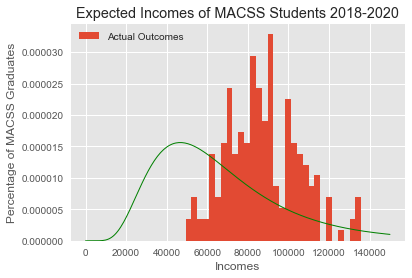

In [17]:
plt.hist(incomes, bins = 30, normed = True, label = 'Actual Outcomes') # real data
plt.title("Expected Incomes of MACSS Students 2018-2020")
plt.xlabel("Incomes")
plt.ylabel("Percentage of MACSS Graduates")
plt.legend(loc = 'upper left')

#lognormal pdf
income_lognorm = log_norm_pdf(xvals = inc_sim, mu = mu_init, sigma = sig_init, cutoff = 150000)
plt.plot(inc_sim, income_lognorm, linewidth = 1, color = 'g')

In [19]:
loglikeval = log_lik_norm(incomes, mu = mu_init, sigma = sig_init, cutoff= 'None') #log  norm liklihood

print('The log liklihood value is', loglikeval)

The log liklihood value is -2385.85699781


mu_MLE= 11.3616965504  sig_MLE= 0.21174668303 

The Value of Liklihood Function is: -2240.93343258
VCV(MLE) =
 [[ 0.84410856 -0.03082385]
 [-0.03082385  0.00125371]] 

Standard error for mu estimate =  0.918753806703
Standard error for sigma estimate =  0.0354077631701


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


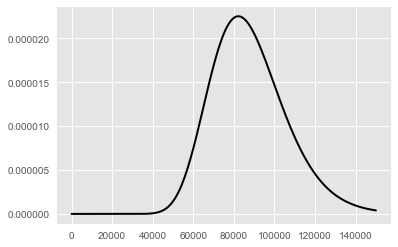

In [21]:
# Estimate Parameters

# run minimizer to get MLE estimates
results1 = opt.minimize(crit, params_init, args=(mle_args), bounds=((None, None),(0.1, None)), method= 'L-BFGS-B')# sigma needs be postive in PDF function.
mu_MLE1, sig_MLE1 = results1.x # get the estimated parameters
print('mu_MLE=', mu_MLE1, ' sig_MLE=', sig_MLE1, '\n')


#get logliklihood value
loglik1 = - results1.fun # get the value of log likehood function
print("The Value of Liklihood Function is:", loglik1)

#VCV
OffDiagNeg = np.array([[1, -1], [-1, 1]]) # this has purpose of making some numbers neg //
vcv_mle = results1.hess_inv.todense() * OffDiagNeg
stderr_mu_mle1 = np.sqrt(vcv_mle[0,0]) # square rooted cause log
stderr_sig_mle1 = np.sqrt(vcv_mle[1,1]) #square rooted cause log
print('VCV(MLE) =\n', vcv_mle, '\n')
print('Standard error for mu estimate = ', stderr_mu_mle1)
print('Standard error for sigma estimate = ', stderr_sig_mle1)

#Plot Line
plt.plot(inc_sim, log_norm_pdf(inc_sim, mu_MLE1, sig_MLE1, 150000), linewidth=2, color='k', label='2: $\mu$=mu_MLE1,$\sigma$=sig_MLE1') # plot PDF with parameters estimated by MLE

In [22]:
# Likelihood Ratio Test
log_lik_h0 = log_lik_norm(incomes,mu_init,sig_init,150000) # real data, initial guess logliklihood
log_lik_mle = log_lik_norm(incomes,mu_MLE1, sig_MLE1,150000) # real data, optimized parameters guess logliklihood
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2) # the probability that H0 is true with two degrees of freedom
print('chi squared of H0 with 2 degrees of freedom p-value = {:.4f} '.format(pval_h0))
print('reject the null hypothesis that data comes from the original model') #Conditional on P Value ##########
#this means that the real data is unlikely to comply from lognorm dist with p mu init, sig init

chi squared of H0 with 2 degrees of freedom p-value = 0.0000 
reject the null hypothesis that data comes from the original model


In [23]:
lessthan75 = sts.lognorm.cdf(75000, s=sig_MLE1, loc=mu_MLE1, scale=np.exp(mu_MLE1)) #notice this is setup for lognorm

print('The probability of earning less than 75k is {:.4f}'.format(lessthan75))

######
morethan100 = 1 - sts.lognorm.cdf(100000, s=sig_MLE1, loc=mu_MLE1, scale=np.exp(mu_MLE1)) #notice this is setup for lognorm

print('The probability of earning more than 100k is {:.5f}'.format(morethan100))

The probability of earning less than 75k is 0.2594
The probability of earning more than 100k is 0.23772


In [24]:
def truncnorm_pdf(xvals, mu, sigma, cutoff): #normal dist w/ truncated
    if cutoff == 'None':
        prob_notcut = 1.0
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

def log_lik_truncnorm(xvals, mu, sigma, cutoff): #log liklihood. In LR, mu = 0, cutoff = 'None'
    pdf_vals = truncnorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

# log_lik_truncnorm(pts, mu_1, sig_1, 450) # uses fake data,

def crit(params, *args): ## criterion function. neg of logliklihood
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cutoff) # setup for NORM pdf
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

def crit_lr(params, *args):
  
    beta0, beta1, beta2, beta3, sigma = params
    y, x1, x2, x3 = args
    xvals = y - beta0 - beta1*x1 - beta2*x2 - beta3*x3 # given the model: error ~ sick - beta0 - beta1*age - beta2*temp - beta3*child
    log_lik_val = log_lik_truncnorm(xvals, 0, sigma, 'None') # get the value of log likelihood function. norm pdf
    neg_log_lik_val = -log_lik_val 
    
    return neg_log_lik_val

In [27]:
#relevant columns
age = df['age']
temp = df['avgtemp_winter']
child = df['children']
sick = df['sick']

# initial guess for five parameters
beta0_init = 1
beta1_init = 0
beta2_init = 0
beta3_init = 0
sig_init_lr = 1 

#concatenate packages
params_init_lr = np.array([beta0_init, beta1_init, beta2_init, beta3_init, sig_init_lr]) 
mle_args_lr = (sick, age, child, temp) # plug in the sick data
bd = ((None, None),(None, None), (None, None), (None, None), (0.001, None))

#estimate parameters 
results_lr = opt.minimize(crit_lr, params_init_lr, args=(mle_args_lr), bounds=bd, method='SLSQP') # plug in initial paramers and data to the crit funtion to search for minimum
beta0_mle, beta1_mle, beta2_mle, beta3_mle, sig_mle = results_lr.x # unpack estimated parameters
print("My parameter estimates are:", results_lr.x)

#log liklihood estimate
print("My logliklihood estimate is: ", results_lr.fun)

#VCV
#need to use different method would improved params
params_init_lr_MLE = np.array([beta0_mle, beta1_mle, beta2_mle, beta3_mle, sig_mle])
results_lr_MLE = opt.minimize(crit_lr, params_init_lr_MLE, args=(mle_args_lr), bounds=bd, method='L-BFGS-B')
vcv_mle_lr = results_lr_MLE.hess_inv.todense()
print('VCV =\n', vcv_mle_lr, '\n')


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


My parameter estimates are: [ 0.25164615  0.01293334  0.40050214 -0.00999166  0.00301772]
My logliklihood estimate is:  -876.865046864978
VCV =
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]] 



/anaconda/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [30]:
#liklihood ratio test (Linear Regression)

b0 = 1
sig0 = 0.1
b1 = 0
b2 = 0
b3 = 0
param_h0 = np.array([b0, b1, b2, b3, sig0]) # note to self: sig last

#set up two hypothesis
log_lik_h02 = - crit_lr(param_h0, *(sick, age, child, temp))
log_lik_mle2 = results_lr.fun

# calculate liklihood ratio test
LR_val2 = 2 * (log_lik_mle2 - log_lik_h02) # get LR value from the likelihood ratio test
pval_h02 = 1.0 - sts.chi2.cdf(LR_val2, 2) # the probability that H0 is true with two degrees of freedom
print('chi squared of H0 with 2 degrees of freedom p-value = {:.5f}'.format(pval_h02))

chi squared of H0 with 2 degrees of freedom p-value = 0.00000
